# Weight Initialization
In this lesson, you'll learn how to find good initial weights for a neural network. Weight initialization happens once, when a model is created and before it trains. Having good initial weights can place the neural network close to the optimal solution. This allows the neural network to come to the best solution quicker. 

<img src="notebook_ims/neuron_weights.png" width=40%/>


## Initial Weights and Observing Training Loss

To see how different weights perform, we'll test on the same dataset and neural network. That way, we know that any changes in model behavior are due to the weights and not any changing data or model structure. 
> We'll instantiate at least two of the same models, with _different_ initial weights and see how the training loss decreases over time, such as in the example below. 

<img src="notebook_ims/loss_comparison_ex.png" width=60%/>

Sometimes the differences in training loss, over time, will be large and other times, certain weights offer only small improvements.

### Dataset and Model

We'll train an MLP to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist) to demonstrate the effect of different initial weights. As a reminder, the FashionMNIST dataset contains images of clothing types; `classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']`. The images are normalized so that their pixel values are in a range [0.0 - 1.0).  Run the cell below to download and load the dataset.

---
#### EXERCISE

[Link to normalized distribution, exercise code](#normalex)

---

### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Processing...
Done!


### Visualize Some Training Data

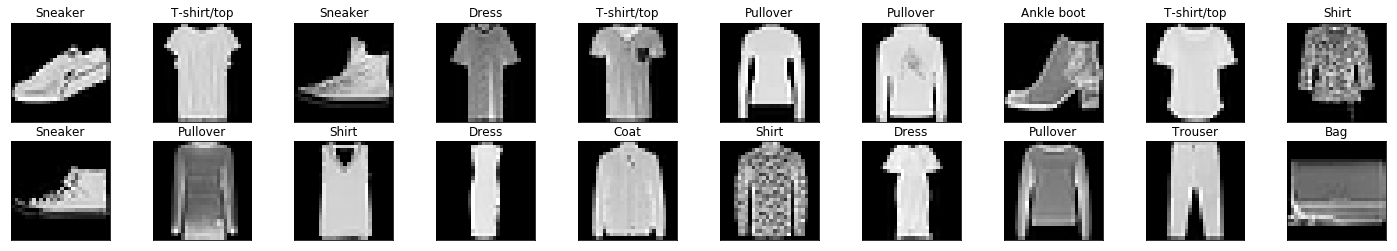

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Define the Model Architecture

We've defined the MLP that we'll use for classifying the dataset.

### Neural Network
<img style="float: left" src="notebook_ims/neural_net.png" width=50%/>


* A 3 layer MLP with hidden dimensions of 256 and 128. 

* This MLP accepts a flattened image (784-value long vector) as input and produces 10 class scores as output.
---
We'll test the effect of different initial weights on this 3 layer neural network with ReLU activations and an Adam optimizer.  

The lessons you learn apply to other neural networks, including different activations and optimizers.

---
## Initialize Weights
Let's start looking at some initial weights.
### All Zeros or Ones
If you follow the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor), you might think setting all the weights to 0 or 1 would be the best solution.  This is not the case.

With every weight the same, all the neurons at each layer are producing the same output.  This makes it hard to decide which weights to adjust.

Let's compare the loss with all ones and all zero weights by defining two models with those constant weights.

Below, we are using PyTorch's [nn.init](https://pytorch.org/docs/stable/nn.html#torch-nn-init) to initialize each Linear layer with a constant weight. The init library provides a number of weight initialization functions that give you the ability to initialize the weights of each layer according to layer type.

In the case below, we look at every layer/module in our model. If it is a Linear layer (as all three layers are for this MLP), then we initialize those layer weights to be a `constant_weight` with bias=0 using the following code:
>```
if isinstance(m, nn.Linear):
    nn.init.constant_(m.weight, constant_weight)
    nn.init.constant_(m.bias, 0)
```

The `constant_weight` is a value that you can pass in when you instantiate the model.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128, constant_weight=None):
        super(Net, self).__init__()
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (hidden_2 -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    
            
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x


### Compare Model Behavior

Below, we are using `helpers.compare_init_weights` to compare the training and validation loss for the two models we defined above, `model_0` and `model_1`.  This function takes in a list of models (each with different initial weights), the name of the plot to produce, and the training and validation dataset loaders. For each given model, it will plot the training loss for the first 100 batches and print out the validation accuracy after 2 training epochs. *Note: if you've used a small batch_size, you may want to increase the number of epochs here to better compare how models behave after seeing a few hundred images.* 

We plot the loss over the first 100 batches to better judge which model weights performed better at the start of training. **I recommend that you take a look at the code in `helpers.py` to look at the details behind how the models are trained, validated, and compared.**

Run the cell below to see the difference between weights of all zeros against all ones.

In [5]:
# initialize two NN's with 0 and 1 constant weights
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)
print(model_0)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


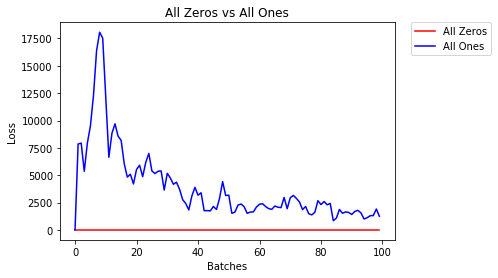

After 2 Epochs:
Validation Accuracy
    9.692% -- All Zeros
    9.917% -- All Ones
Training Loss
    2.304  -- All Zeros
  409.198  -- All Ones


In [6]:
import helpers

# put them in list form to compare
model_list = [(model_0, 'All Zeros'),
              (model_1, 'All Ones')]


# plot the loss over the first 100 batches
helpers.compare_init_weights(model_list, 
                             'All Zeros vs All Ones', 
                             train_loader,
                             valid_loader)

As you can see the accuracy is close to guessing for both zeros and ones, around 10%.

The neural network is having a hard time determining which weights need to be changed, since the neurons have the same output for each layer.  To avoid neurons with the same output, let's use unique weights.  We can also randomly select these weights to avoid being stuck in a local minimum for each run.

A good solution for getting these random weights is to sample from a uniform distribution.

### Uniform Distribution
A [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous%29) has the equal probability of picking any number from a set of numbers. We'll be picking from a continuous distribution, so the chance of picking the same number is low. We'll use NumPy's `np.random.uniform` function to pick random numbers from a uniform distribution.

>#### [`np.random_uniform(low=0.0, high=1.0, size=None)`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html)
>Outputs random values from a uniform distribution.

>The generated values follow a uniform distribution in the range [low, high). The lower bound minval is included in the range, while the upper bound maxval is excluded.

>- **low:** The lower bound on the range of random values to generate. Defaults to 0.
- **high:** The upper bound on the range of random values to generate. Defaults to 1.
- **size:** An int or tuple of ints that specify the shape of the output array.

We can visualize the uniform distribution by using a histogram. Let's map the values from `np.random_uniform(-3, 3, [1000])` to a histogram using the `helper.hist_dist` function. This will be `1000` random float values from `-3` to `3`, excluding the value `3`.

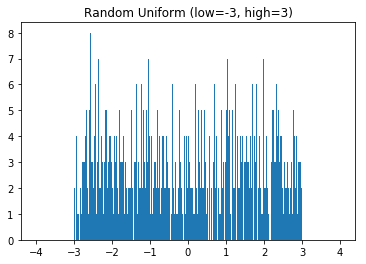

In [7]:
helpers.hist_dist('Random Uniform (low=-3, high=3)', np.random.uniform(-3, 3, [1000]))

The histogram used 500 buckets for the 1000 values.  Since the chance for any single bucket is the same, there should be around 2 values for each bucket. That's exactly what we see with the histogram.  Some buckets have more and some have less, but they trend around 2.

Now that you understand the uniform function, let's use PyTorch's `nn.init` to apply it to a model's initial weights.

### Uniform Initialization, Baseline


Let's see how well the neural network trains using a uniform weight initialization, where `low=0.0` and `high=1.0`. Below, I'll show you another way (besides in the Net class code) to initialize the weights of a network. To define weights outside of the model definition, you can:
>1. Define a function that assigns weights by the type of network layer, *then* 
2. Apply those weights to an initialized model using `model.apply(fn)`, which applies a function to each model layer.

This time, we'll use `weight.data.uniform_` to initialize the weights of our model, directly.

In [8]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [9]:
# create a new model with these weights
model_uniform = Net()
model_uniform.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

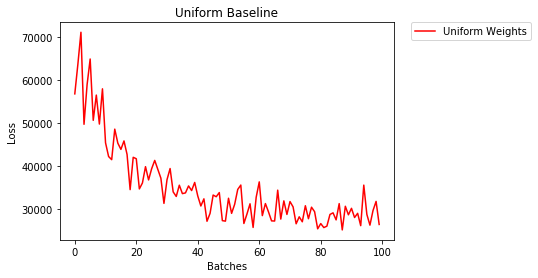

After 2 Epochs:
Validation Accuracy
   33.658% -- Uniform Weights
Training Loss
    4.951  -- Uniform Weights


In [10]:
# evaluate behavior 
helpers.compare_init_weights([(model_uniform, 'Uniform Weights')], 
                             'Uniform Baseline', 
                             train_loader,
                             valid_loader)

---
The loss graph is showing the neural network is learning, which it didn't with all zeros or all ones. We're headed in the right direction!

## General rule for setting weights
The general rule for setting the weights in a neural network is to set them to be close to zero without being too small. 
>Good practice is to start your weights in the range of $[-y, y]$ where $y=1/\sqrt{n}$  
($n$ is the number of inputs to a given neuron).

Let's see if this holds true; let's create a baseline to compare with and center our uniform range over zero by shifting it over by 0.5.  This will give us the range [-0.5, 0.5).

In [11]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a centered, uniform distribution to the weights
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

# create a new model with these weights
model_centered = Net()
model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

Then let's create a distribution and model that uses the **general rule** for weight initialization; using the range $[-y, y]$, where $y=1/\sqrt{n}$ .

And finally, we'll compare the two models.

In [12]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model_rule = Net()
model_rule.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

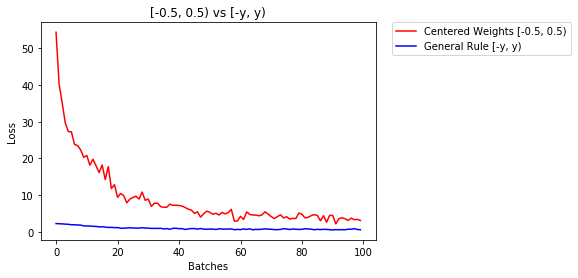

After 2 Epochs:
Validation Accuracy
   75.525% -- Centered Weights [-0.5, 0.5)
   85.733% -- General Rule [-y, y)
Training Loss
    0.468  -- Centered Weights [-0.5, 0.5)
    0.391  -- General Rule [-y, y)


In [13]:
# compare these two models
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5)'), 
              (model_rule, 'General Rule [-y, y)')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             '[-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)

This behavior is really promising! Not only is the loss decreasing, but it seems to do so very quickly for our uniform weights that follow the general rule; after only two epochs we get a fairly high validation accuracy and this should give you some intuition for why starting out with the right initial weights can really help your training process!

---

Since the uniform distribution has the same chance to pick *any value* in a range, what if we used a distribution that had a higher chance of picking numbers closer to 0?  Let's look at the normal distribution.

### Normal Distribution
Unlike the uniform distribution, the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) has a higher likelihood of picking number close to it's mean. To visualize it, let's plot values from NumPy's `np.random.normal` function to a histogram.

>[np.random.normal(loc=0.0, scale=1.0, size=None)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html)

>Outputs random values from a normal distribution.

>- **loc:** The mean of the normal distribution.
- **scale:** The standard deviation of the normal distribution.
- **shape:** The shape of the output array.

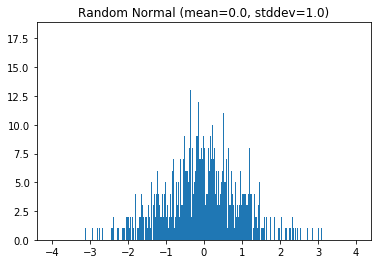

In [14]:
helpers.hist_dist('Random Normal (mean=0.0, stddev=1.0)', np.random.normal(size=[1000]))

Let's compare the normal distribution against the previous, rule-based, uniform distribution.

<a id='normalex'></a>
#### TODO: Define a weight initialization function that gets weights from a normal distribution 
> The normal distribution should have a mean of 0 and a standard deviation of $y=1/\sqrt{n}$

In [17]:
## complete this function
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

In [18]:
## -- no need to change code below this line -- ##

# create a new model with the rule-based, uniform weights
model_uniform_rule = Net()
model_uniform_rule.apply(weights_init_uniform_rule)

# create a new model with the rule-based, NORMAL weights
model_normal_rule = Net()
model_normal_rule.apply(weights_init_normal)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

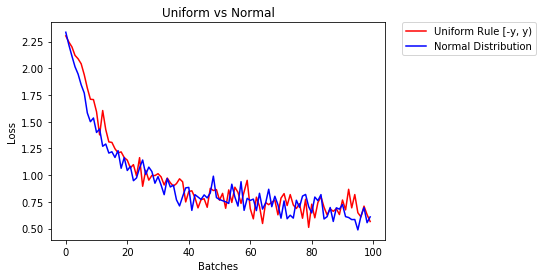

After 2 Epochs:
Validation Accuracy
   85.983% -- Uniform Rule [-y, y)
   85.525% -- Normal Distribution
Training Loss
    0.355  -- Uniform Rule [-y, y)
    0.377  -- Normal Distribution


In [19]:
# compare the two models
model_list = [(model_uniform_rule, 'Uniform Rule [-y, y)'), 
              (model_normal_rule, 'Normal Distribution')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             'Uniform vs Normal', 
                             train_loader,
                             valid_loader)

The normal distribution gives us pretty similar behavior compared to the uniform distribution, in this case. This is likely because our network is so small; a larger neural network will pick more weight values from each of these distributions, magnifying the effect of both initialization styles. In general, a normal distribution will result in better performance for a model.


---

### Automatic Initialization

Let's quickly take a look at what happens *without any explicit weight initialization*.

In [22]:
## Instantiate a model with _no_ explicit weight initialization 
model_no_initialization = Net()

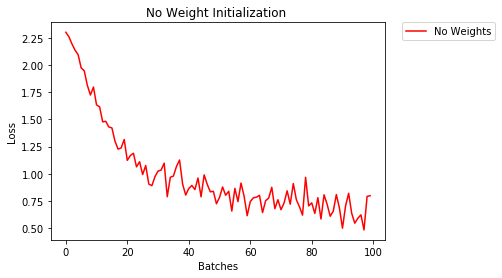

After 2 Epochs:
Validation Accuracy
   85.733% -- No Weights
Training Loss
    0.496  -- No Weights


In [23]:
## evaluate the behavior using helpers.compare_init_weights

model_list = [(model_no_initialization, 'No Weights')]

# evaluate behavior 
helpers.compare_init_weights(model_list, 
                             'No Weight Initialization ', 
                             train_loader,
                             valid_loader)

As you complete this exercise, keep in mind these questions:
* What initializaion strategy has the lowest training loss after two epochs? What about highest validation accuracy?
* After testing all these initial weight options, which would you decide to use in a final classification model?

no initialization and uniform initialzation behavior is almost similar ..as oytorch has default initialization similar to uniform one